### Import All Results

We need to parse multiple CSV files into a single data-frame. The headers for each are as follows:
```
"Benchmark","Mode","Threads","Samples","Score","Score Error (99,9%)","Unit","Param: configStr"
```
We are mostly interested in "Benchmark", "Score", "Score Error (99,9%)", and "Unit.

The directory format for the data we need to parse is as follows:
```
 |- results
    |- <driver>
       |- <project>
          |- results-Xmx<mem>G-write.csv
          |- results-Xmx<mem>G-read.csv
```
The driver, project, and memory information also need to become columns in the dataframe.

In [29]:
import os
import pandas as pd

# Define the directory containing the results
base_dir = 'results'

# Define the columns of interest
columns_of_interest = ["Benchmark", "Score", "Score Error (99,9%)", "Unit"]

# List to store individual dataframes
dataframes = []

# Walk through the directory structure
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)

            # Extract <driver>, <project>, and <mem> from the path
            parts = file_path.split(os.sep)
            driver = parts[1]
            project = parts[2]
            mem = file.split('-')[1][3:-1]  # Extracting <mem> from 'results-Xmx<mem>G-*.csv'
            typ = file.split('-')[2].split('.')[0]

            # Read the CSV file
            df = pd.read_csv(file_path, usecols=columns_of_interest) #, dtype={'Score': float, 'Score Error (99,9%)': float})

            # Rename the column "Score Error (99,9%)" to "Error"
            df.rename(columns={"Score Error (99,9%)": "Error"}, inplace=True)

            # Add the extracted information as new columns
            df['Driver'] = driver
            df['Project'] = project
            df['Mem'] = mem
            df['Type'] = typ
            
            # Clean score data
            df['Score'] = df['Score'].replace(',','.', regex=True).astype(float)
            df['Error']  = df['Error'].replace(',','.', regex=True).astype(float)

            # Append the dataframe to the list
            dataframes.append(df)

# Concatenate all dataframes into a single dataframe
final_df = pd.concat(dataframes, ignore_index=True)

# Display the final dataframe
print(final_df)


                                             Benchmark         Score  \
0    com.github.plume.oss.benchmarking.OverflowDbRe...  1.980871e+07   
1    com.github.plume.oss.benchmarking.OverflowDbRe...  1.761000e+03   
2    com.github.plume.oss.benchmarking.OverflowDbRe...  5.872026e+07   
3    com.github.plume.oss.benchmarking.OverflowDbRe...  5.662310e+07   
4    com.github.plume.oss.benchmarking.OverflowDbRe...  2.116420e+09   
..                                                 ...           ...   
187  com.github.plume.oss.benchmarking.GraphWriteBe...  1.344151e+08   
188  com.github.plume.oss.benchmarking.GraphWriteBe...  1.332199e+08   
189  com.github.plume.oss.benchmarking.GraphWriteBe...  1.332199e+08   
190  com.github.plume.oss.benchmarking.GraphWriteBe...  1.344151e+08   
191  com.github.plume.oss.benchmarking.GraphWriteBe...  2.182044e+07   

            Error   Unit      Driver   Project Mem   Type  
0    1.454257e+06  ns/op  overflowdb  compress   2   READ  
1             N

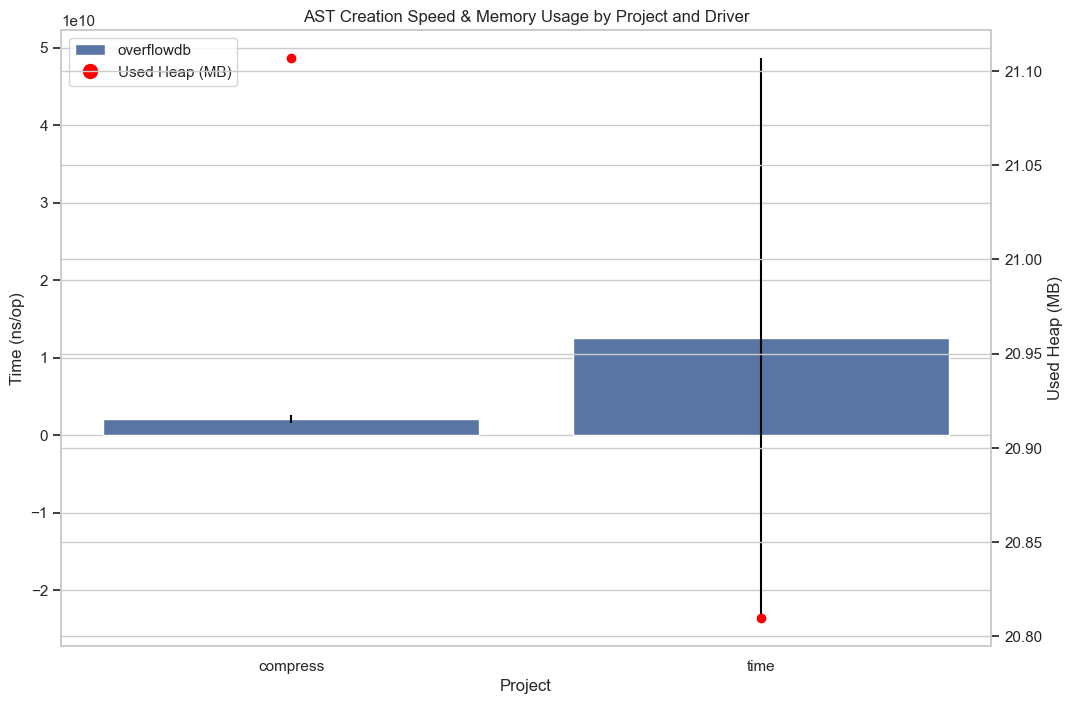

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

write_df_create_ast = final_df[(final_df['Type'].str.lower() == 'write') & (final_df['Benchmark'].str.endswith('createAst'))]

# Filter the data for Benchmark ending with 'usedHeap'
filtered_df_usedHeap = final_df[(final_df['Type'].str.lower() == 'write') & (final_df['Benchmark'].str.endswith('usedHeap'))]

# Convert 'Score' from bytes to megabytes for 'usedHeap' entries
filtered_df_usedHeap.loc[filtered_df_usedHeap['Unit'] == 'bytes', 'Score'] /= (1024 * 1024)
filtered_df_usedHeap.loc[filtered_df_usedHeap['Unit'] == 'bytes', 'Unit'] = 'megabytes'

# Plotting with Seaborn and Matplotlib
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the bar plot for createAst
sns.barplot(x="Project", y="Score", hue="Driver", data=write_df_create_ast, errorbar=None, ax=ax1)

# Adding error bars manually
for i, row in write_df_create_ast.iterrows():
    plt.errorbar(x=row['Project'], y=row['Score'], yerr=row['Error'], fmt='none', c='black')

# Set labels and title for the first y-axis
ax1.set_xlabel('Project')
ax1.set_ylabel(f'Time ({write_df_create_ast["Unit"].iloc[0]})')
ax1.set_title('AST Creation Speed & Memory Usage by Project and Driver')

# Create a second y-axis for usedHeap
ax2 = ax1.twinx()


# Add points for usedHeap
ax2.scatter(filtered_df_usedHeap['Project'], filtered_df_usedHeap['Score'], color='red', label='Used Heap (MB)')
ax2.set_ylabel('Used Heap (MB)')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2 = [plt.Line2D([0], [0], marker='o', color='red', linestyle='', markersize=10)]
labels_2 = ['Used Heap (MB)']
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Show the plot
plt.show()